In [1]:
from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image
from torch.autograd import Variable
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
import gc
import saliency.core as saliency
from torchvision import models, transforms
from tqdm import tqdm

cudnn.benchmark = True

In [2]:
def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)


In [4]:

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
BLACK  = Image.fromarray(np.zeros((299, 299, 3), dtype=np.uint8))
BLACK = preprocess(BLACK)[None]
# BLACK = torch.from_numpy(BLACK[None]) # adds extra first dimension 

In [6]:
def straight_path_images(model, images, n_steps):
    
    x_diff = images - BLACK
    path_images = []
    
    for alpha in np.linspace(0, 1, n_steps):
        x_step = BLACK + alpha * x_diff
        path_images.append(x_step)
    
    path_images = torch.stack(path_images).transpose(0, 1)

    # returns x sequence
    return path_images

In [7]:
model = models.inception_v3(pretrained=True, init_weights=False).to('cuda:0', non_blocking=True)
model.eval()

for param in model.parameters():
    param.requires_grad = False

c:\Users\singh\.conda\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\singh\.conda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
images = torch.stack([preprocess(Image.open("doberman.png")), preprocess(Image.open("doggo.webp"))])
sequence = straight_path_images(model, images, 25)

In [20]:
def straight_path_images(images, n_steps):
    x_diff = images - BLACK
    path_images = []
    
    for alpha in np.linspace(0, 1, n_steps):
        x_step = BLACK + alpha * x_diff
        path_images.append(x_step)
    
    path_images = torch.stack(path_images).transpose(0, 1)

    # returns x sequence
    return path_images

def IG(model, images, class_idx, n_steps=25):
    sequence = straight_path_images(images, n_steps).to('cuda:0', non_blocking=True)
    image_shape = sequence.shape[2:]
    batchSize = sequence.shape[0]
    frames = sequence.shape[1]
    
    reshaped_sequence = sequence.view((batchSize*frames,)+image_shape)
    reshaped_sequence.requires_grad = True

    output = model(reshaped_sequence)

    output = torch.nn.Softmax(dim=1)(output)
    output = output[:, class_idx]  # index that particular class
    gradients = torch.autograd.grad(output, reshaped_sequence, grad_outputs=torch.ones_like(output))[0].view(sequence.shape).detach()

    summands =  (gradients[:,1:] * (sequence[:,1:]-sequence[:,:-1]))
    out = summands.detach().sum(1).to('cpu:0', non_blocking=True).numpy()
    del reshaped_sequence, output, gradients, summands

    return out
            
saliency_IG = IG(model, sequence, class_idxs=[236]*len(sequence)).transpose(0,2,3,1)


TypeError: IG() got an unexpected keyword argument 'class_idxs'

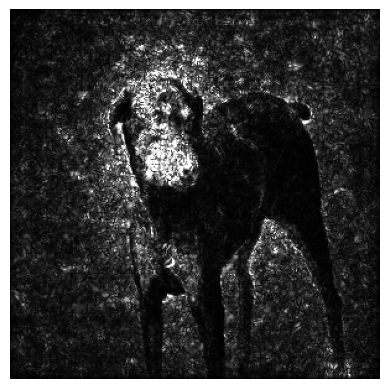

In [7]:
ShowGrayscaleImage(saliency.VisualizeImageGrayscale(saliency_IG[0]))

In [22]:
def IDGI2(model, sequence, class_idxs):
    image_shape = sequence.shape[2:]
    batchSize = sequence.shape[0]
    frames = sequence.shape[1]
    
    classes = np.repeat(class_idxs, frames)
    sequence = sequence.clone().to('cuda:0', non_blocking=True)

    reshaped_sequence = sequence.reshape((batchSize*frames,)+image_shape)
    reshaped_sequence.requires_grad = True

    output = model(reshaped_sequence)

    output = torch.nn.Softmax(dim=1)(output)
    output = output[np.arange(batchSize*frames), classes]  # index that particular class for each image

    gradients = torch.autograd.grad(output, reshaped_sequence, grad_outputs=torch.ones_like(output))[0].view(sequence.shape).detach()
    output = output.detach().view((batchSize, frames))
                
    # we ignore the last gradient, e.g., the gradient of on the original image, since IDGI requires the prediction difference component, i.e., d.
    d = output[:,1:] - output[:, :-1]
    element_product = gradients[:,:-1]**2
    result = (element_product*d.view(batchSize,frames-1,1,1,1)/element_product.sum((2,3,4)).view(batchSize,frames-1,1,1,1)).sum(1)

    out = result.detach().to('cpu:0', non_blocking=True).numpy().transpose(0,2,3,1)
    del output, gradients, reshaped_sequence, sequence, element_product, d, result

    return out

saliency_IDGI2 = IDGI2(model, sequence, class_idxs=[236, 236])


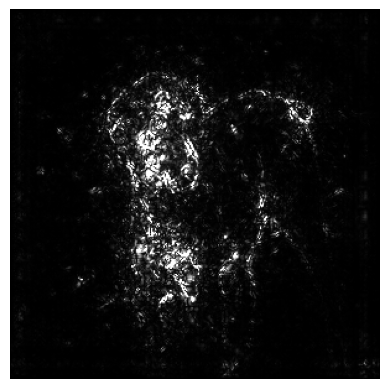

In [15]:
ShowGrayscaleImage(saliency.VisualizeImageGrayscale(saliency_IDGI2[0]))

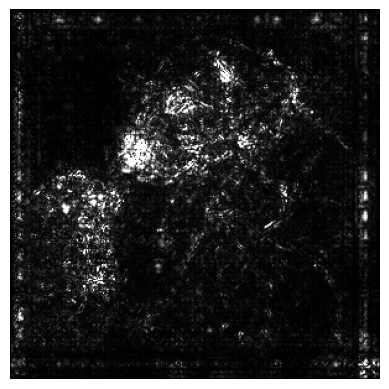

In [23]:
ShowGrayscaleImage(saliency.VisualizeImageGrayscale(saliency_IDGI2[1]))

In [26]:
def IDGI(model, sequence, class_idxs):
    image_shape = sequence.shape[2:]
    batchSize = sequence.shape[0]
    frames = sequence.shape[1]
    
    classes = np.repeat(class_idxs, frames)
    sequence = sequence.clone().to('cuda:0', non_blocking=True)

    reshaped_sequence = sequence.reshape((batchSize*frames,)+image_shape)
    reshaped_sequence.requires_grad = True

    output = model(reshaped_sequence)

    output = torch.nn.Softmax(dim=1)(output)
    output = output[np.arange(batchSize*frames), classes]  # index that particular class for each image

    gradients = torch.autograd.grad(output, reshaped_sequence, grad_outputs=torch.ones_like(output))[0].view(sequence.shape).detach()
    output = output.detach().view((batchSize, frames))
                
    result = torch.zeros((batchSize,)+image_shape).to('cuda:0', non_blocking=True)
    for i in range(sequence.shape[1] - 1):
        # we ignore the last gradient, e.g., the gradient of on the original image, since IDGI requires the prediction difference component, i.e., d.
        d = output[:,i+1] - output[:, i]
        element_product = gradients[:,i]**2
        result += element_product*d.view(-1,1,1,1)/element_product.sum((1,2,3)).view(-1,1,1,1)

    out = result.detach().to('cpu:0', non_blocking=True).numpy().transpose(0,2,3,1)
    del output, gradients, reshaped_sequence, sequence, element_product, d, result

    return out

saliency_IDGI = IDGI(model, sequence, class_idxs=[236, 236])


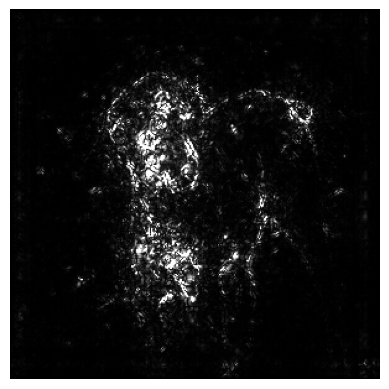

In [27]:
ShowGrayscaleImage(saliency.VisualizeImageGrayscale(saliency_IDGI[0]))

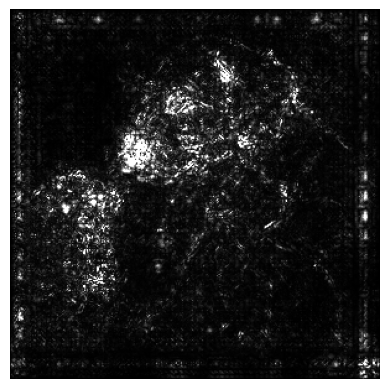

In [28]:
ShowGrayscaleImage(saliency.VisualizeImageGrayscale(saliency_IDGI[1]))

In [19]:
INFINITY = torch.Tensor([float("inf")]).to('cuda:0', non_blocking=True)
NAN = torch.Tensor([float("nan")]).to('cuda:0', non_blocking=True)

In [12]:
def l1_distance(x1, x2):
    return (x1 - x2).abs().sum()
def translate_x_to_alpha(x, x_input, x_baseline):
    return torch.where(x_input - x_baseline != 0,
                      (x - x_baseline) / (x_input - x_baseline), NAN)

    # return (x - x_baseline) / (x_input - x_baseline)
def translate_alpha_to_x(alpha, x_input, x_baseline):
    return x_baseline + (x_input - x_baseline) * alpha

In [13]:
def grad_func(model, x, class_idxs):
    model.eval()

    x.requires_grad = True
    classes = np.array(class_idxs)

    output = model(x)
    output = torch.nn.Softmax(dim=1)(output)
    output = output[np.arange(output.shape[0]), classes]  # index that particular class for each image
    gradient = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output))[0].view(x.shape).detach()

    x.requires_grad = False
    del output

    return gradient

In [14]:
from tqdm.auto import tqdm

In [59]:
epsilon = 1E-4

def guided_ig_impl(model, x_input, x_baseline, grad_func, class_idxs, steps=25, fraction=0.50, max_dist=1.0):
  x_baseline = x_baseline.clone().to('cuda:0', non_blocking=True)
  x_input = x_input.clone().to('cuda:0', non_blocking=True)
  x = x_baseline.clone().to('cuda:0', non_blocking=True)
  l1_total = l1_distance(x_input, x_baseline)
  # print(l1_total.item())
  attr = torch.zeros_like(x_input)

  for step in range(steps):
    grad_actual = grad_func(model, x, class_idxs)
    grad = grad_actual.clone().to('cuda:0', non_blocking=True)
    alpha = (step + 1.0) / steps
    alpha_min = max(alpha - max_dist, 0.0)
    alpha_max = min(alpha + max_dist, 1.0)
    x_min = translate_alpha_to_x(alpha_min, x_input, x_baseline)
    x_max = translate_alpha_to_x(alpha_max, x_input, x_baseline)

    l1_target = l1_total * (1 - (step + 1) / steps)

    gamma = INFINITY
    while gamma > 1.0:
      x_old = x.clone()
      x_alpha = translate_x_to_alpha(x, x_input, x_baseline)
      x_alpha[torch.isnan(x_alpha)] = alpha_max

      x[x_alpha < alpha_min] = x_min[x_alpha < alpha_min]

      l1_current = l1_distance(x, x_input)


      if torch.isclose(l1_target, l1_current, rtol=epsilon, atol=epsilon):
        attr += (x - x_old) * grad_actual
        break

      grad[x == x_max] = INFINITY
      # print(x_alpha.abs().mean().item())

      threshold = torch.quantile(grad.abs(), fraction, interpolation="lower")
      print(threshold.item())
      s = torch.logical_and(grad.abs() <= threshold,  torch.logical_not(torch.isinf(grad)))
      # print(torch.logical_not(torch.isinf(grad)).shape)

      l1_s = ((x - x_max).abs() * s).sum()
      # print(s.float().mean().item())

      # print(l1_target.item(), l1_current.item(), gamma.item(), l1_s.item())

      if l1_s > 0:
        gamma = (l1_current - l1_target) / l1_s
      else:
        gamma = INFINITY

      if gamma > 1.0:
        x[s] = x_max[s]
      else:
        assert gamma > 0, gamma
        x[s] = translate_alpha_to_x(gamma, x_max, x)[s]
      attr += (x - x_old) * grad_actual
  return attr

In [60]:
saliency_GIG = guided_ig_impl(model, images, BLACK , grad_func, class_idxs = [236], steps=5)
saliency_GIG = saliency_GIG.transpose(0,2,3,1)

TypeError: quantile() received an invalid combination of arguments - got (Tensor, float, interpolation=str), but expected one of:
 * (Tensor input, Tensor q, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, float q, int dim, bool keepdim, *, Tensor out)


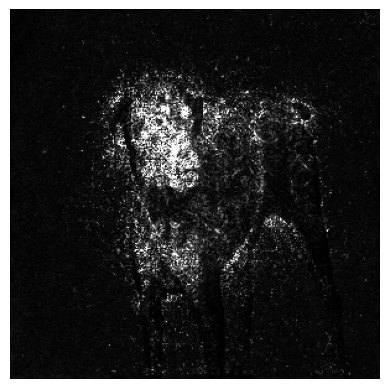

In [ ]:
ShowGrayscaleImage(saliency.VisualizeImageGrayscale(saliency_GIG[0]))